In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.decomposition import PCA
from MulticoreTSNE import MulticoreTSNE as TSNE
import umap

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Загрузка основного датафрейма с результатами голосований
df_full = pd.read_csv('./data/df_full_cr_0.csv', index_col=0)

In [3]:
df_full.head(3)

,law_name,vote_result,Авдеев Александр Александрович,Адучиев Батор Канурович,Азимов Рахим Азизбоевич,Аксаков Анатолий Геннадьевич,Алексеева Татьяна Олеговна,Альшевских Андрей Геннадьевич,Ананских Игорь Александрович,Аникеев Григорий Викторович,...,Эмиргамзаев Абдулгамид Гасанович,Юмашева Инга Альбертовна,Юрков Дмитрий Васильевич,Ющенко Александр Андреевич,Ямпольская Елена Александровна,Яровая Ирина Анатольевна,Курдюмов Александр Борисович,Антошкин Николай Тимофеевич,Кобзев Юрий Викторович,Шурчанов Валентин Сергеевич
114772,(за основу) О проекте порядка работы Государст...,принят,-1,-1,-1,0,-1,-1,0,-1,...,0,0,-1,-1,-1,-1,0,0,0,0
114771,Регистрация,принят,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
114770,(первое чтение) О проекте федерального закона ...,отклонен,0,0,0,0,0,0,0,0,...,0,0,0,-1,0,0,0,0,0,0


2 - не голосовал, 1 - "против", 0 - воздержался, -1 - "за"

In [4]:
# Загрузка таблицы со списком депутатов и их партий
dep_df_cr = pd.read_csv('./data/dep_df_cr.csv', index_col=0, squeeze=True)
dep_df_cr.name = 'Партии'
dep_df_cr.head(3)

Авдеев Александр Александрович    ЕР
Адучиев Батор Канурович           ЕР
Азимов Рахим Азизбоевич           ЕР
Name: Партии, dtype: object

In [5]:
# Транспонирование матрицы для последующей кластеризации
df_t = df_full.transpose().drop(index=['law_name', 'vote_result'])
df_t.head(3)

,114772,114771,114770,114769,114768,114767,114766,114765,114764,114763,...,96016,96015,96014,96013,96012,96011,96010,96009,96008,96007
Авдеев Александр Александрович,-1,0,0,0,0,0,0,0,0,0,...,-1,0,-1,-1,-1,-1,-1,-1,-1,0
Адучиев Батор Канурович,-1,0,0,0,0,0,0,0,0,0,...,-1,0,-1,-1,-1,-1,-1,-1,-1,0
Азимов Рахим Азизбоевич,-1,0,0,0,0,0,0,0,0,0,...,-1,0,-1,-1,-1,-1,-1,-1,-1,0


In [6]:
X = df_t # Матрица для кластеризации
y = dep_df_cr # Данные о партийной принадлежности

In [7]:
def plot(x1, x2, hue=None, name=None):
    plt.figure(figsize=(10,10))
    sns.scatterplot(x1, x2, hue=hue, palette="bright")
    plt.title(name, fontsize=18)
    plt.show()

### Отображаем нашу матрицу в двухмерное пространство с помощью PCA, UMAP и t-SNE и смотрим, что получилось

### PCA

In [8]:
pca = PCA(random_state=7)
pca.fit(X)

PCA(random_state=7)

In [9]:
PCA_transformed = PCA(n_components=2, random_state=7).fit_transform(X)
PCA_transformed.shape

(406, 2)

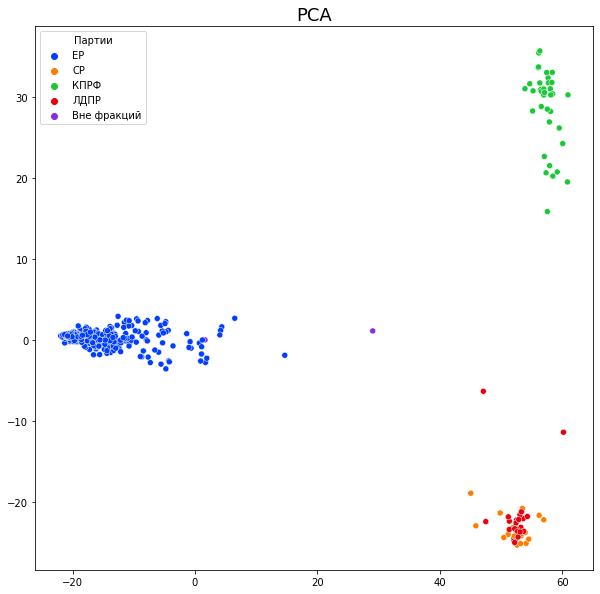

In [11]:
plot(PCA_transformed[:, 0], PCA_transformed[:, 1], hue=y, name='PCA')

### UMAP

In [12]:
reducer = umap.UMAP(random_state=7)
embedding = reducer.fit_transform(X)

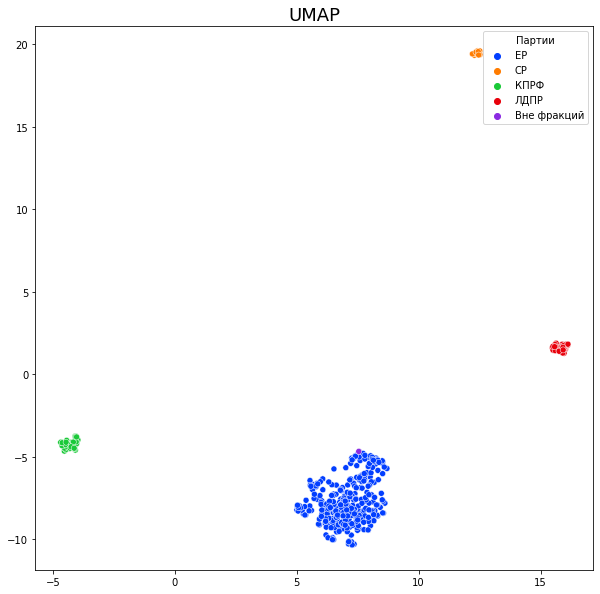

In [13]:
plot(embedding[:, 0], embedding[:, 1], hue=y, name='UMAP')

### t-SNE

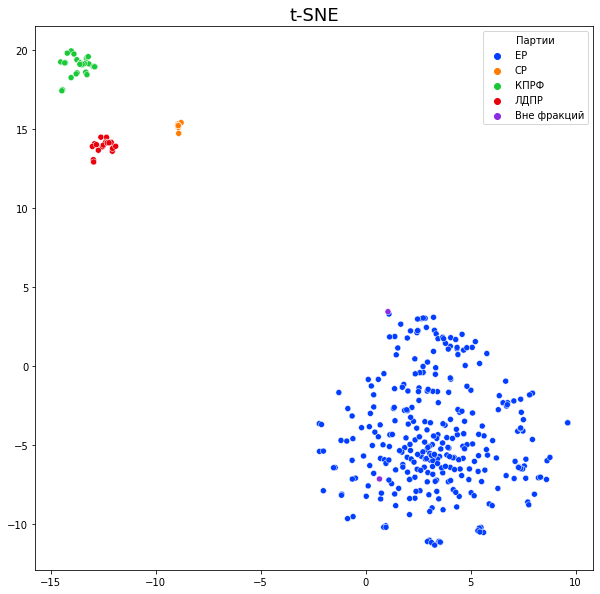

In [14]:
tsne = TSNE(n_jobs=-1, random_state=7)
tsne_transformed = tsne.fit_transform(X)

plot(tsne_transformed[:,0], tsne_transformed[:,1], hue=y, name='t-SNE')

# Кластеризация

## K-means алгоритм

Elbow method

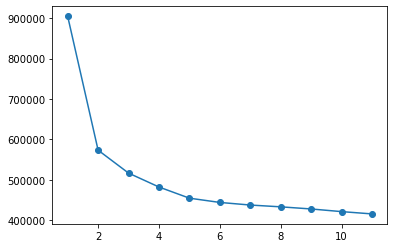

In [15]:
inertia = []
for i in range(1,12):
    kmeans = KMeans(n_clusters=i, random_state=7, n_jobs=-1).fit(X)
    inertia_i = kmeans.inertia_
    inertia.append(inertia_i)
    
plt.plot(range(1,12), inertia, marker='o')

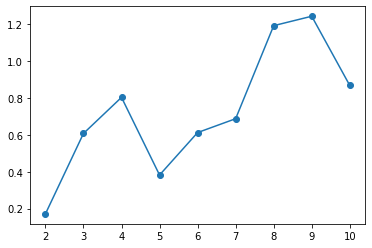

In [16]:
D = []
for i in range(1,10):
    Di = (inertia[i] - inertia[i+1]) / (inertia[i-1] - inertia[i])
    D.append(Di)
    
plt.plot(range(2,11), D, marker='o')

Silhouette plot

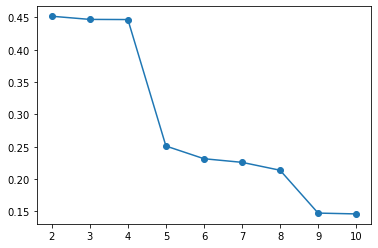

In [17]:
silhouette = []
for i in range(2,11):
    kmeans = KMeans(n_clusters=i, random_state=7, n_jobs=-1).fit(X)
    labels = kmeans.labels_
    score = silhouette_score(X, labels)
    silhouette.append(score)

plt.plot(range(2,11), silhouette, marker='o')

По силуэтному графику видно, что максимальное число кластеров, на которое хорошо делятся данные, равно 4

In [18]:
kmeans_4 = KMeans(n_clusters=4, random_state=7, n_jobs=-1).fit(X)
labels_km_4 = kmeans_4.labels_

### PCA

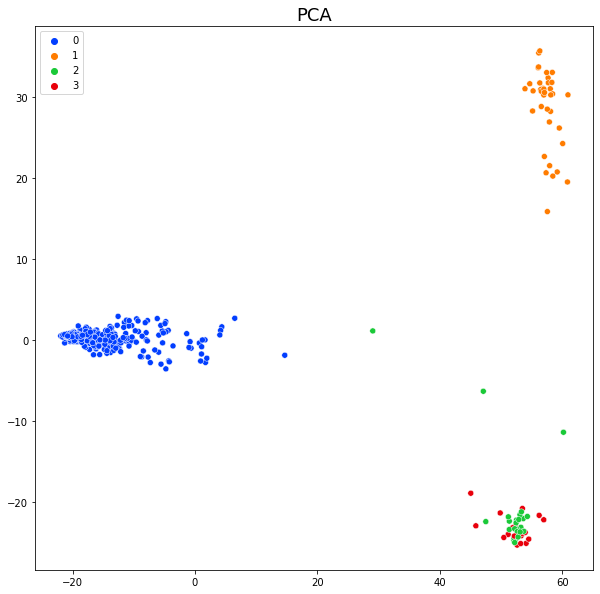

In [19]:
plot(PCA_transformed[:, 0], PCA_transformed[:, 1], hue=labels_km_4, name='PCA')

### UMAP

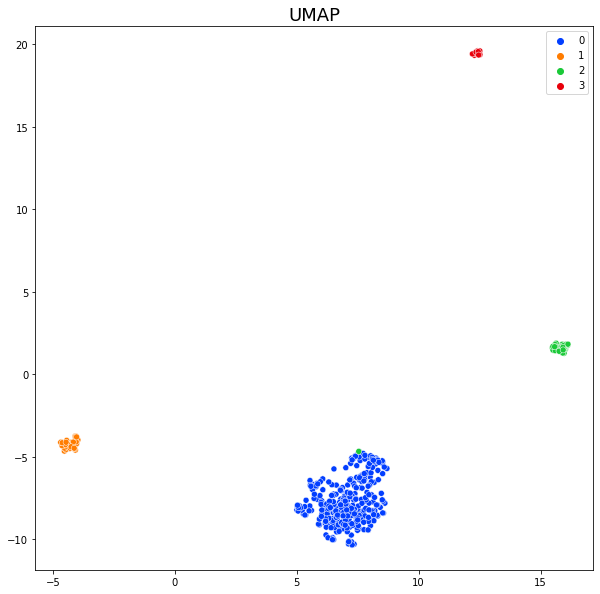

In [20]:
plot(embedding[:, 0], embedding[:, 1], hue=labels_km_4, name='UMAP')

### t-SNE

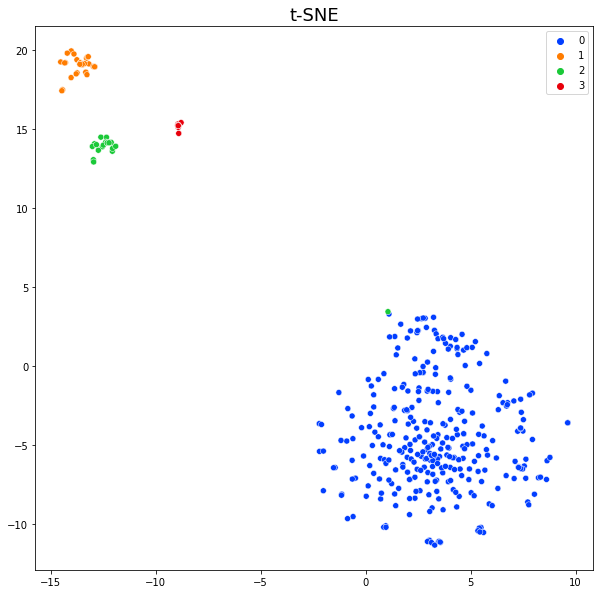

In [21]:
plot(tsne_transformed[:,0], tsne_transformed[:,1], hue=labels_km_4, name='t-SNE')

При использовании UMAP/t-SNE и алгоритма K-means разделение на партийные кластеры происходит отлично. PCA даёт менее внятный визуальный результат

## hierarhical алгоритм

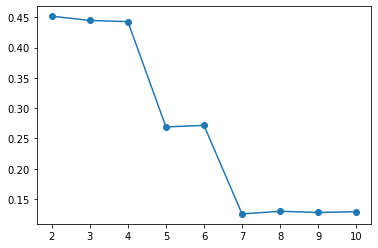

In [22]:
silhouette = []
for i in range(2,11):
    agg = AgglomerativeClustering(n_clusters=i).fit(X)
    labels = agg.labels_
    score = silhouette_score(X, labels, random_state=7)
    silhouette.append(score)
    
plt.plot(range(2,11), silhouette, marker='o')

In [23]:
agg_4 = AgglomerativeClustering(n_clusters=4).fit(X)
labels_hier_4 = agg_4.labels_

### PCA

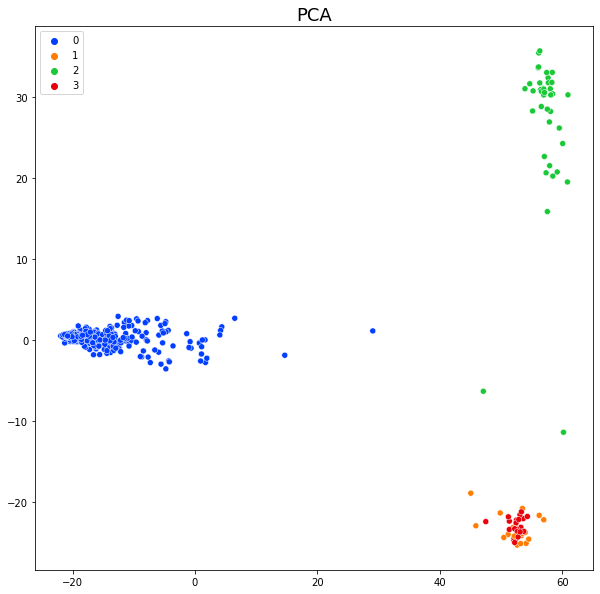

In [24]:
plot(PCA_transformed[:, 0], PCA_transformed[:, 1], hue=labels_hier_4, name='PCA')

### UMAP

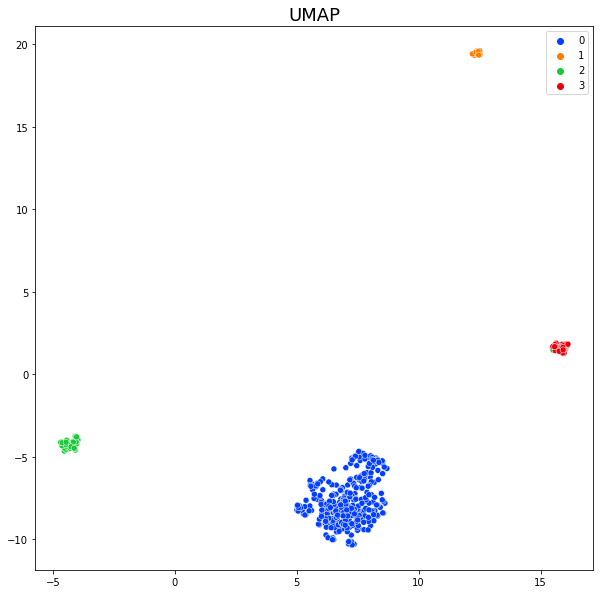

In [25]:
plot(embedding[:, 0], embedding[:, 1], hue=labels_hier_4, name='UMAP')

### t-SNE

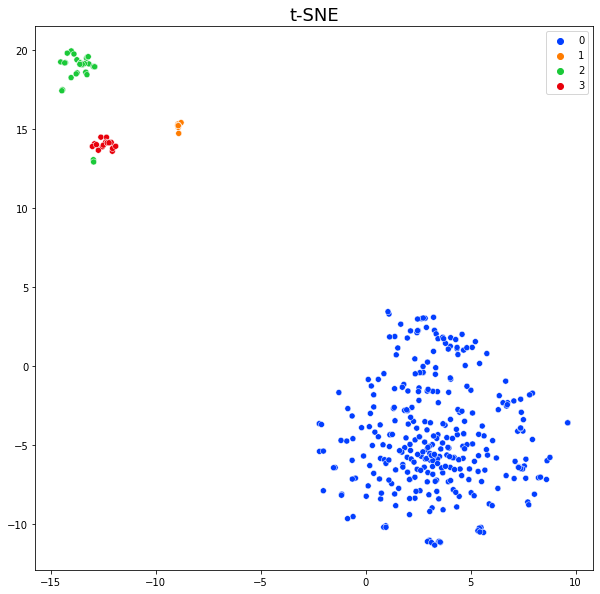

In [26]:
plot(tsne_transformed[:,0], tsne_transformed[:,1], hue=labels_hier_4, name='t-SNE')

Алгоритм hierarhical справился с кластеризацией на уровне K-means

### Определение возможности кластеризации внутри партий

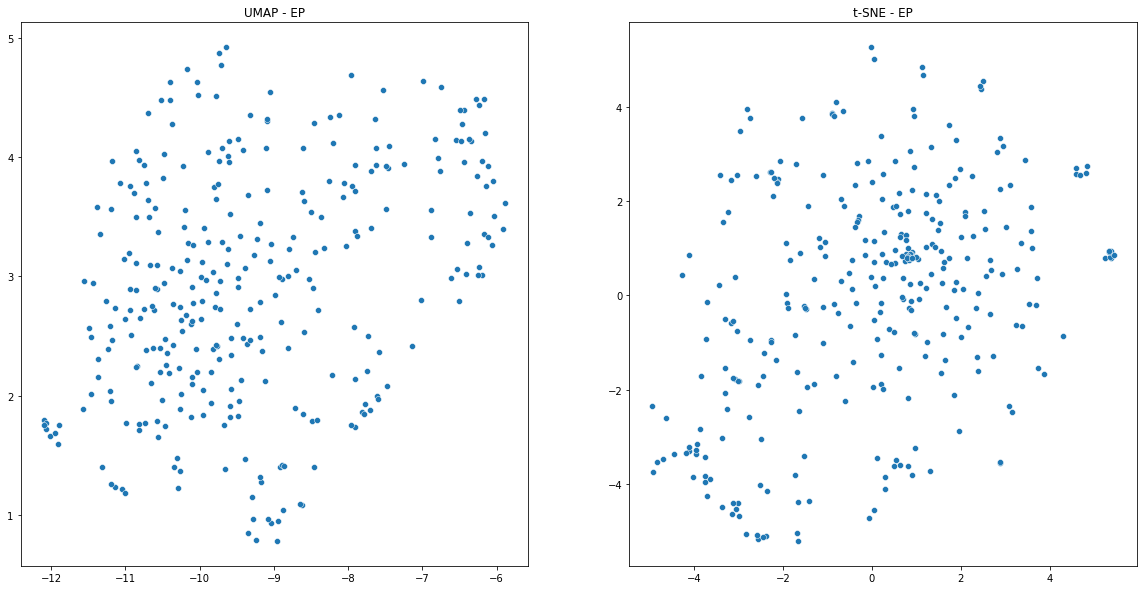

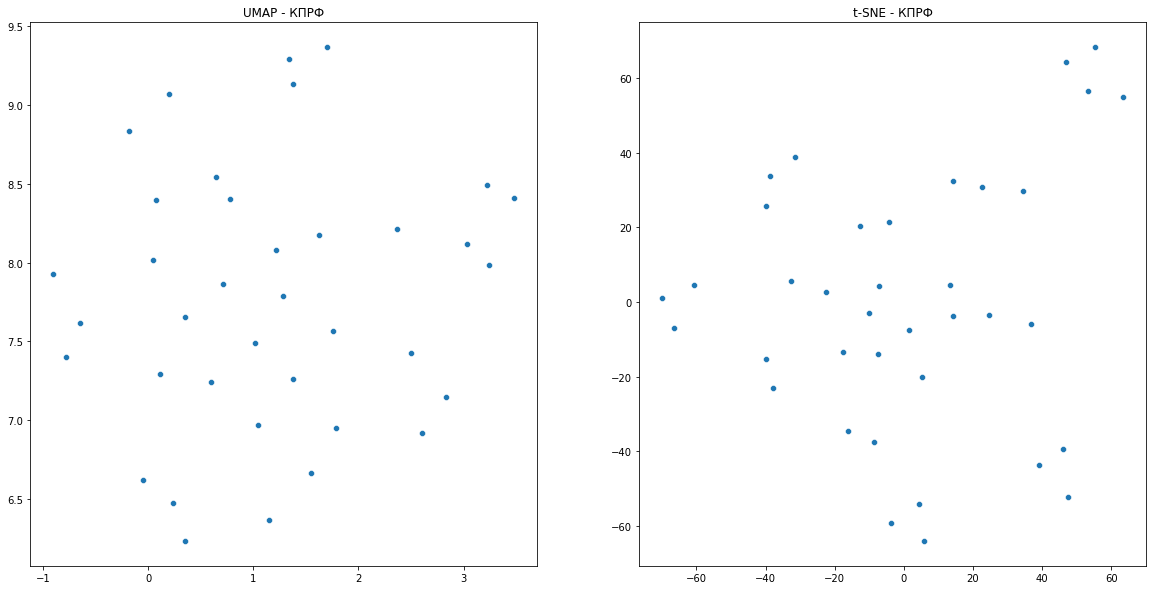

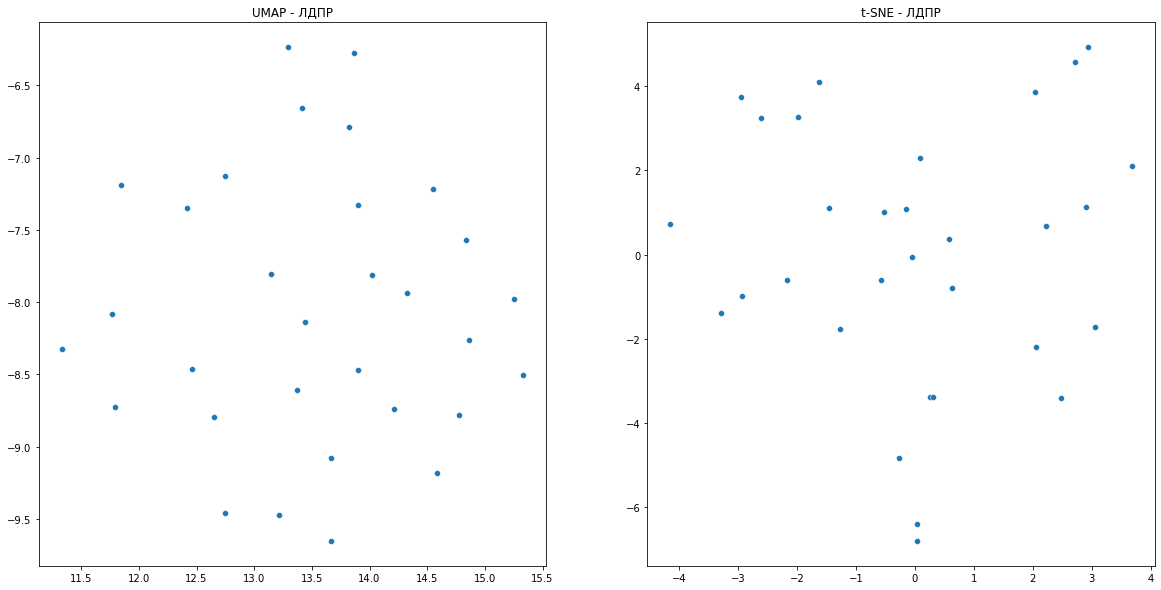

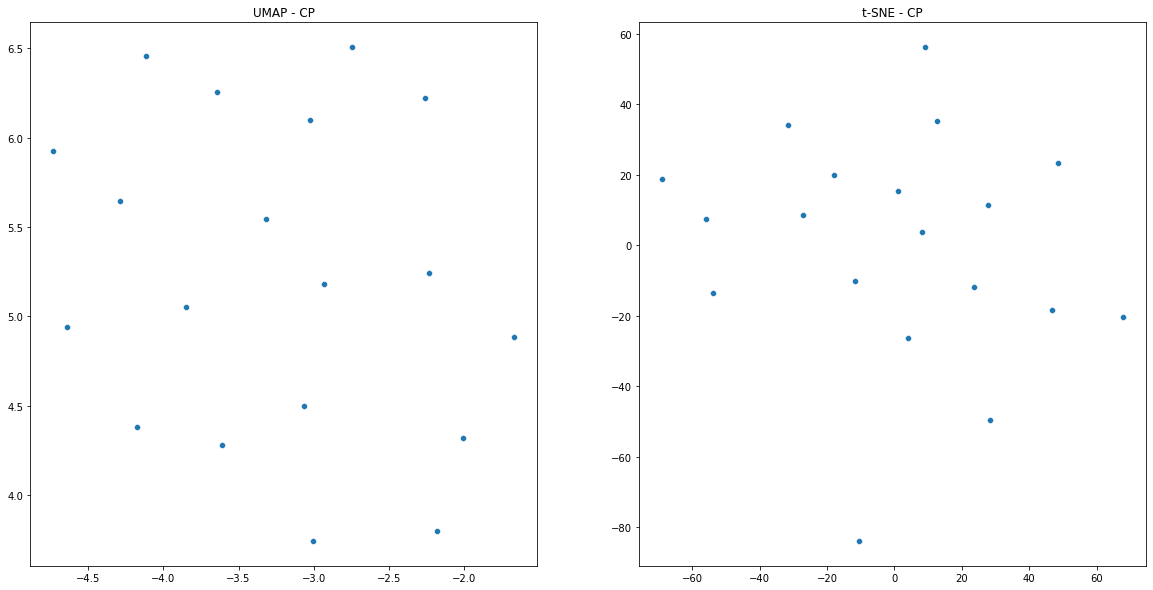

In [27]:
p_list = ['ЕР', 'КПРФ', 'ЛДПР', 'СР']

for p in p_list:

    X = df_t.loc[dep_df_cr[dep_df_cr == p].index, :]
    y = dep_df_cr[dep_df_cr == p]

    embedding = reducer.fit_transform(X)
    tsne_transformed = tsne.fit_transform(X)

    plt.figure(figsize=(20,10))

    ax1 = plt.subplot(1, 2, 1)
    sns.scatterplot(x=embedding[:, 0], y=embedding[:, 1])
    ax1.set_title(f"UMAP - {p}")

    ax2 = plt.subplot(1, 2, 2)
    sns.scatterplot(tsne_transformed[:,0], tsne_transformed[:,1])
    ax2.set_title(f"t-SNE - {p}")

    plt.show()

Исходя из картинок, которые дают UMAP и t-SNE, явная кластеризация внутри партий отсутствует